In [1]:
from faker import Faker
import random
import pandas as pd
import numpy as np
from scipy.integrate import quad
from datetime import datetime, timedelta
import csv
from scipy.stats import norm
from kennitala import generate_kennitala

import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

In [2]:
age_distribution = pd.read_csv('icelandic_age_distribution_postprocessed.csv')

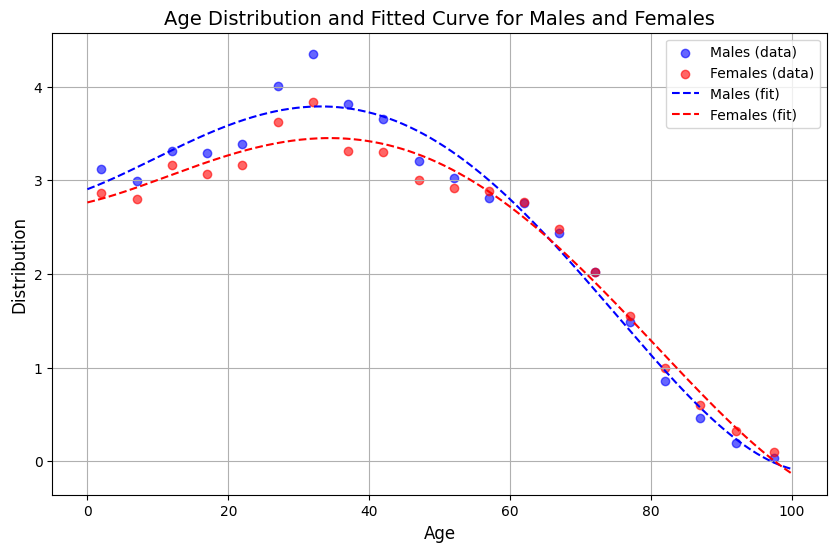

In [3]:
# Calculate midpoints for each age group
age_distribution["Midpoint"] = (
    age_distribution["Min Age"] + age_distribution["Max Age"]) / 2

# Fit a polynomial curve for Males and Females
x = age_distribution["Midpoint"]
y_males = age_distribution["Males"]
y_females = age_distribution["Females"]

# Fit polynomials of degree 4
male_poly = np.polyfit(x, y_males, 4)
female_poly = np.polyfit(x, y_females, 4)

male_curve = np.poly1d(male_poly)
female_curve = np.poly1d(female_poly)

# Generate smooth x values for plotting the curve
x_smooth = np.linspace(0, 100, 500)
y_male_smooth = male_curve(x_smooth)
y_female_smooth = female_curve(x_smooth)

# Plot the distributions and fitted curves
plt.figure(figsize=(10, 6))

# Original data points
plt.scatter(x, y_males, color='blue', label='Males (data)', alpha=0.6)
plt.scatter(x, y_females, color='red', label='Females (data)', alpha=0.6)

# Fitted curves
plt.plot(x_smooth, y_male_smooth, color='blue',
         linestyle='--', label='Males (fit)')
plt.plot(x_smooth, y_female_smooth, color='red',
         linestyle='--', label='Females (fit)')

# Styling the plot
plt.title("Age Distribution and Fitted Curve for Males and Females", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Distribution", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

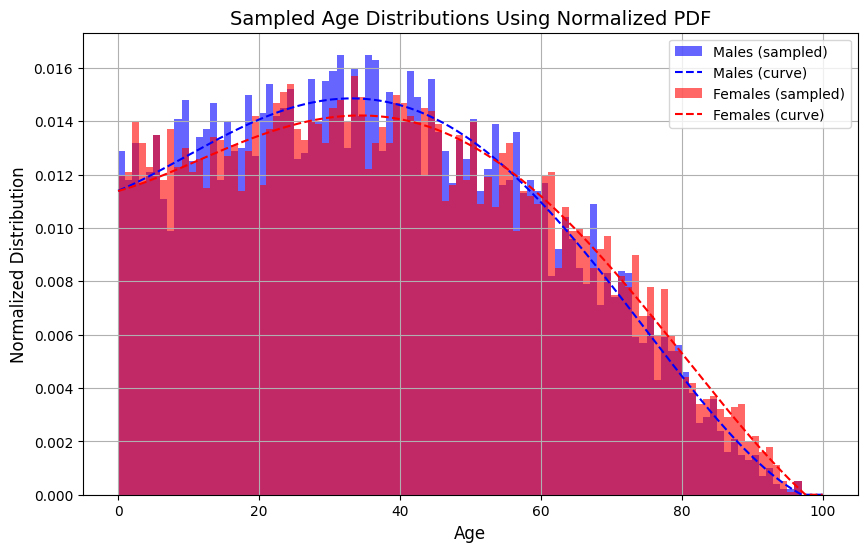

In [4]:
# Define adjusted curves ensuring non-negativity
def adjusted_curve(curve, x):
    return max(0, curve(x))

# Normalize the curve to create a valid PDF


def normalize_curve(curve):
    normalization_factor, _ = quad(lambda x: max(0, curve(x)), 0, 100)
    return lambda x: max(0, curve(x)) / normalization_factor


male_pdf = normalize_curve(male_curve)
female_pdf = normalize_curve(female_curve)

# Generate samples from the PDF


def sample_from_pdf(pdf, num_samples):
    x_vals = np.linspace(0, 100, 1000)
    probabilities = np.array([pdf(x) for x in x_vals])
    probabilities /= probabilities.sum()
    return np.random.choice(x_vals, size=num_samples, p=probabilities)


# Example usage
num_samples = 10000
male_samples = sample_from_pdf(male_pdf, num_samples)
female_samples = sample_from_pdf(female_pdf, num_samples)

# Plot the results


def plot_distribution(samples, pdf, label, color):
    plt.hist(samples, bins=range(101), alpha=0.6, color=color,
             label=f'{label} (sampled)', density=True)
    x_vals = np.linspace(0, 100, 500)
    plt.plot(x_vals, [pdf(x) for x in x_vals], linestyle='--',
             color=color, label=f'{label} (curve)')


plt.figure(figsize=(10, 6))
plot_distribution(male_samples, male_pdf, 'Males', 'blue')
plot_distribution(female_samples, female_pdf, 'Females', 'red')
plt.title('Sampled Age Distributions Using Normalized PDF', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Normalized Distribution', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [5]:
x_vals = np.linspace(0, 100, 500)
male_y_vals = [male_pdf(x) for x in x_vals]
female_y_vals = [female_pdf(x) for x in x_vals]

with open('age_curves.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "Male_PDF", "Female_PDF"])
    for x, male_y, female_y in zip(x_vals, male_y_vals, female_y_vals):
        writer.writerow([x, male_y, female_y])

In [6]:
fake = Faker()
# Create DataFrame for male samples
male_df = pd.DataFrame({
    'Name': [fake.name_male() for _ in range(len(male_samples))],
    'Age': male_samples,
    'Gender': ['Male'] * len(male_samples)
})

# Create DataFrame for female samples
female_df = pd.DataFrame({
    'Name': [fake.name_female() for _ in range(len(female_samples))],
    'Age': female_samples,
    'Gender': ['Female'] * len(female_samples)
})

# Combine both DataFrames
combined_df = pd.concat([male_df, female_df], ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df)

                   Name        Age  Gender
0       Daniel Gallegos  40.040040    Male
1          Keith Holmes  52.052052    Male
2           Matthew Kim  43.743744    Male
3      Cameron Galloway  39.739740    Male
4            Jason Hood  31.631632    Male
...                 ...        ...     ...
19995     Taylor Watson  56.656657  Female
19996     Sylvia Henson  23.623624  Female
19997   Leslie Stephens  34.234234  Female
19998     Abigail Smith  28.128128  Female
19999   Theresa Rosario  47.047047  Female

[20000 rows x 3 columns]


In [7]:
combined_df = combined_df[(combined_df['Age'] > 16)
                          & (combined_df['Age'] < 80)]

# Display the first few rows of the filtered dataframe
display(combined_df)

,Name,Age,Gender
0,Daniel Gallegos,40.040040,Male
1,Keith Holmes,52.052052,Male
2,Matthew Kim,43.743744,Male
3,Cameron Galloway,39.739740,Male
4,Jason Hood,31.631632,Male
...,...,...,...
19995,Taylor Watson,56.656657,Female
19996,Sylvia Henson,23.623624,Female
19997,Leslie Stephens,34.234234,Female
19998,Abigail Smith,28.128128,Female


In [8]:
# Define function to convert age to birth date
def age_to_birth_date(age_samples, reference_date):
    reference_date = datetime.strptime(reference_date, "%d.%m.%y")
    birth_dates = [reference_date -
                   timedelta(days=int(age * 365.25)) for age in age_samples]
    return birth_dates

In [9]:
reference_date = "01.01.25"

In [10]:
# Convert ages to birth dates for the combined dataframe
combined_birth_dates = age_to_birth_date(combined_df['Age'], reference_date)

# Add the birth dates as a new column to the combined dataframe
combined_df['Birth Date'] = combined_birth_dates

# Display the first few rows of the updated dataframe
print(combined_df.head())

               Name        Age Gender Birth Date
0   Daniel Gallegos  40.040040   Male 1984-12-18
1      Keith Holmes  52.052052   Male 1972-12-13
2       Matthew Kim  43.743744   Male 1981-04-05
3  Cameron Galloway  39.739740   Male 1985-04-07
4        Jason Hood  31.631632   Male 1993-05-16


In [11]:
# Convert birth dates to 'ddmmyy' format
combined_df['Birth Date Str'] = combined_df['Birth Date'].dt.strftime('%d%m%y')

# Generate kennitala for each birth date
combined_df['Kennitala'] = combined_df['Birth Date Str'].apply(
    generate_kennitala)

# Drop the temporary 'Birth Date Str' column
combined_df.drop(columns=['Birth Date Str'], inplace=True)

# Check for duplicate kennitalas and keep only the first occurrence
combined_df = combined_df.drop_duplicates(subset=['Kennitala'], keep='first')

# Assert all kennitalas are unique
assert combined_df['Kennitala'].is_unique, f"Kennitalas are not unique! {combined_df['Kennitala'].value_counts()}"


# Display the first few rows of the updated dataframe
display(combined_df)

,Name,Age,Gender,Birth Date,Kennitala
0,Daniel Gallegos,40.040040,Male,1984-12-18,1812848863
1,Keith Holmes,52.052052,Male,1972-12-13,1312728390
2,Matthew Kim,43.743744,Male,1981-04-05,0504818779
3,Cameron Galloway,39.739740,Male,1985-04-07,0704858912
4,Jason Hood,31.631632,Male,1993-05-16,1605938436
...,...,...,...,...,...
19993,Teresa Spencer,53.153153,Female,1971-11-07,0711718760
19995,Taylor Watson,56.656657,Female,1968-05-07,0705688521
19996,Sylvia Henson,23.623624,Female,2001-05-19,1905018724
19997,Leslie Stephens,34.234234,Female,1990-10-08,0810908698


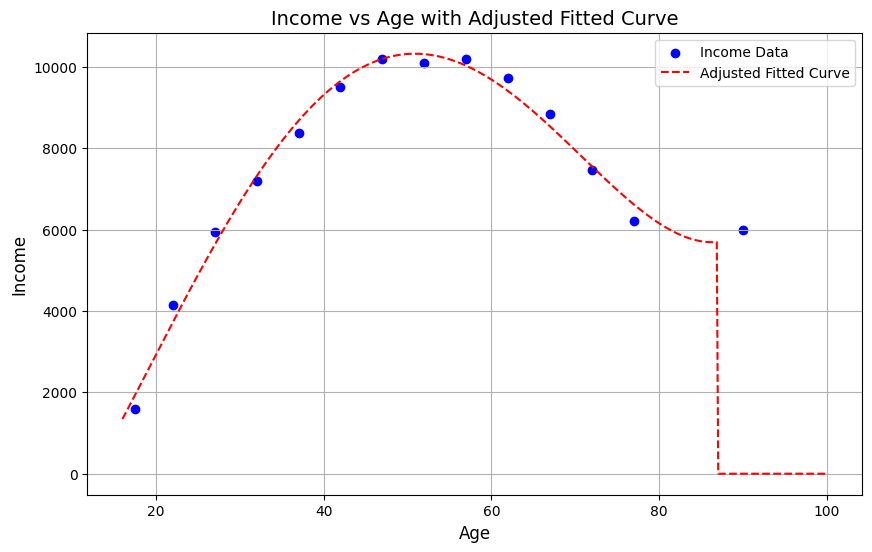

In [12]:
# Load the Icelandic income distribution data
icelandic_income_distribution = pd.read_csv(
    'icelandic_income_distribution_postprocessed.csv')

# Fit polynomial curve for income based on age
icelandic_income_distribution['Midpoint'] = (
    icelandic_income_distribution['Min Age'] + icelandic_income_distribution['Max Age']) / 2

# Function to fit income curve


def fit_income_curve(x, y, degree=4):
    coefficients = np.polyfit(x, y, degree)
    return np.poly1d(coefficients)


# Fit the income curve
income_curve = fit_income_curve(
    icelandic_income_distribution['Midpoint'], icelandic_income_distribution['Income'])

# Adjust the curve to be 0 below 16 and above 85


def adjusted_income_curve(age):
    if age < 16 or age > 87:
        return 0
    return income_curve(age)
# Function to calculate income for a given age with random variation


# Plot the income data and adjusted fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(icelandic_income_distribution['Midpoint'],
            icelandic_income_distribution['Income'], color='blue', label='Income Data')
age_range = np.linspace(16, 100, 500)
plt.plot(age_range, [adjusted_income_curve(age) for age in age_range],
         color='red', linestyle='--', label='Adjusted Fitted Curve')
plt.title('Income vs Age with Adjusted Fitted Curve', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

x_vals = np.linspace(0, 100, 500)
income_vals = [adjusted_income_curve(x) for x in x_vals]

with open('income_curve.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "Income"])
    for x, income in zip(x_vals, income_vals):
        writer.writerow([x, income])

In [13]:
def generate_income_for_user(age, gender='Male'):
    if age < 16 or age > 85:
        return 0
    base_income = adjusted_income_curve(age)
    gender_factor = 1.0 if gender == 'Male' else 0.9
    # Positive-only distribution with mean 1
    random_factor = np.abs(norm.rvs(loc=1, scale=0.1))
    return gender_factor * base_income * random_factor

# Function to calculate incomes for a vector of ages


def generate_incomes_for_ages(age_vector, gender_vector):
    return [generate_income_for_user(age, gender) for age, gender in zip(age_vector, gender_vector)]

In [14]:
# Generate incomes for the combined dataframe
combined_df['Income'] = generate_incomes_for_ages(
    combined_df['Age'], combined_df['Gender'])

# Display the first few rows of the updated dataframe
display(combined_df)

,Name,Age,Gender,Birth Date,Kennitala,Income
0,Daniel Gallegos,40.040040,Male,1984-12-18,1812848863,8875.771714
1,Keith Holmes,52.052052,Male,1972-12-13,1312728390,10195.904727
2,Matthew Kim,43.743744,Male,1981-04-05,0504818779,9727.392885
3,Cameron Galloway,39.739740,Male,1985-04-07,0704858912,9942.523831
4,Jason Hood,31.631632,Male,1993-05-16,1605938436,7245.201793
...,...,...,...,...,...,...
19993,Teresa Spencer,53.153153,Female,1971-11-07,0711718760,9536.194864
19995,Taylor Watson,56.656657,Female,1968-05-07,0705688521,7549.349968
19996,Sylvia Henson,23.623624,Female,2001-05-19,1905018724,4456.684792
19997,Leslie Stephens,34.234234,Female,1990-10-08,0810908698,7009.207417


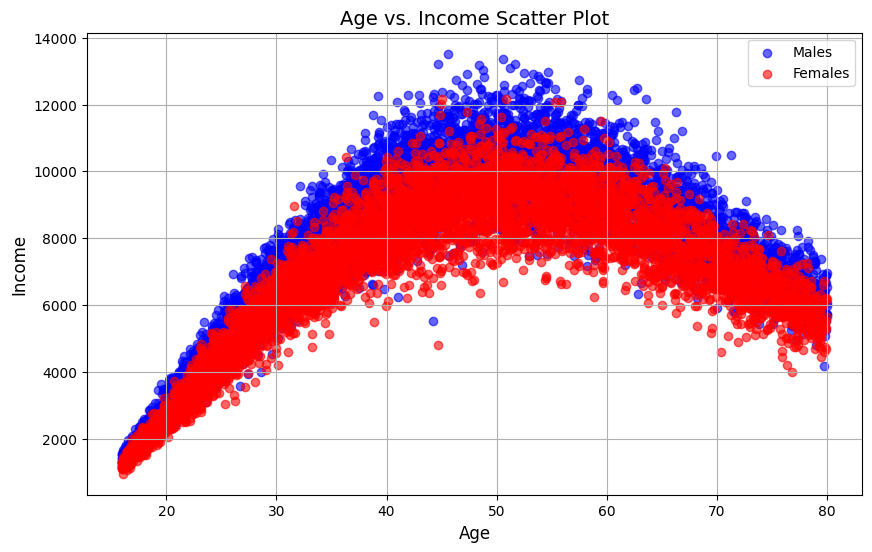

In [15]:
# Scatter plot of Age vs. Income
plt.figure(figsize=(10, 6))

# Plot males
plt.scatter(combined_df[combined_df['Gender'] == 'Male']['Age'],
            combined_df[combined_df['Gender'] == 'Male']['Income'],
            color='blue', label='Males', alpha=0.6)

# Plot females
plt.scatter(combined_df[combined_df['Gender'] == 'Female']['Age'],
            combined_df[combined_df['Gender'] == 'Female']['Income'],
            color='red', label='Females', alpha=0.6)

# Styling the plot
plt.title('Age vs. Income Scatter Plot', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Income', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

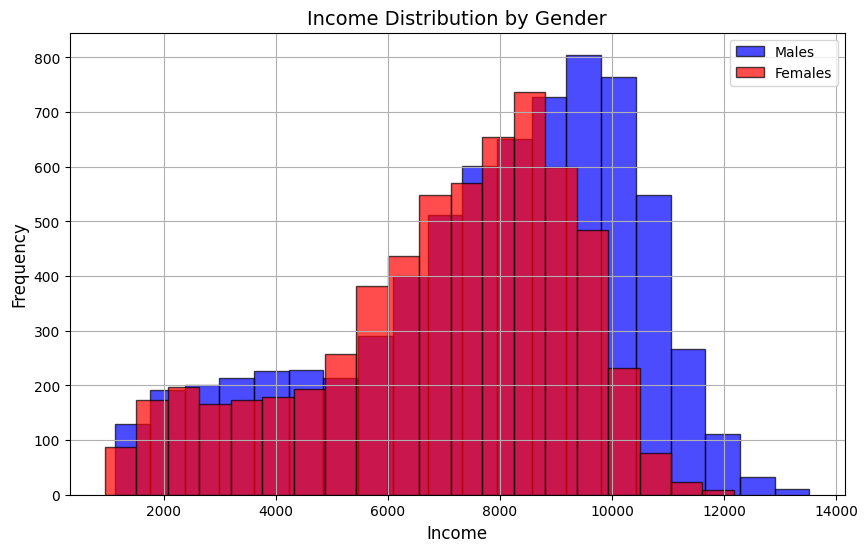

In [16]:
# Filter the combined dataframe to exclude rows with an income of 0
filtered_df = combined_df[combined_df['Income'] > 0]

# Plot income distribution for males and females
plt.figure(figsize=(10, 6))

# Plot males
plt.hist(filtered_df[filtered_df['Gender'] == 'Male']['Income'],
         bins=20, edgecolor='k', alpha=0.7, color='blue', label='Males')

# Plot females
plt.hist(filtered_df[filtered_df['Gender'] == 'Female']['Income'],
         bins=20, edgecolor='k', alpha=0.7, color='red', label='Females')

# Styling the plot
plt.title('Income Distribution by Gender', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Generate email addresses for each entry in the combined dataframe
combined_df['Email'] = [fake.email() for _ in range(len(combined_df))]

# Display the first few rows of the updated dataframe
display(combined_df)

,Name,Age,Gender,Birth Date,Kennitala,Income,Email
0,Daniel Gallegos,40.040040,Male,1984-12-18,1812848863,8875.771714,douglasmary@example.net
1,Keith Holmes,52.052052,Male,1972-12-13,1312728390,10195.904727,kristina12@example.com
2,Matthew Kim,43.743744,Male,1981-04-05,0504818779,9727.392885,reneebrady@example.com
3,Cameron Galloway,39.739740,Male,1985-04-07,0704858912,9942.523831,suttonsamantha@example.com
4,Jason Hood,31.631632,Male,1993-05-16,1605938436,7245.201793,tylerjackson@example.org
...,...,...,...,...,...,...,...
19993,Teresa Spencer,53.153153,Female,1971-11-07,0711718760,9536.194864,jessicamalone@example.net
19995,Taylor Watson,56.656657,Female,1968-05-07,0705688521,7549.349968,eholland@example.net
19996,Sylvia Henson,23.623624,Female,2001-05-19,1905018724,4456.684792,sheryl64@example.net
19997,Leslie Stephens,34.234234,Female,1990-10-08,0810908698,7009.207417,laurenhoward@example.net


In [18]:
hagstofa_df = combined_df.copy()
hagstofa_df.to_csv('hagstofa_data.csv', index=False)

In [19]:
medical_df = combined_df.sample(n=5000, random_state=42)

# Display the first few rows of the sampled dataframe
display(medical_df)

,Name,Age,Gender,Birth Date,Kennitala,Income,Email
8462,Kyle Holland,41.341341,Male,1983-08-31,3108838670,10419.545344,barry29@example.org
3290,Peter Lee,32.832833,Male,1992-03-03,0303928045,7966.049395,andrewcarr@example.org
3275,Robert Burgess,56.856857,Male,1968-02-24,2402688386,8875.020911,billyneal@example.org
3838,Christopher White,76.076076,Male,1948-12-05,0512488669,6442.462490,louis54@example.net
18252,Lauren Duncan,18.618619,Female,2006-05-21,2105068245,2069.355329,sara94@example.net
...,...,...,...,...,...,...,...
4966,Joshua Trujillo,17.117117,Male,2007-11-20,2011078258,1735.424398,klin@example.com
17533,Brittany Robertson,22.222222,Female,2002-10-13,1310028956,4119.171872,martinelizabeth@example.net
11952,Monique Brown,43.643644,Female,1981-05-12,1205818963,8829.444604,hallkim@example.com
11011,Lindsey Larson,63.563564,Female,1961-06-10,1006618728,7973.503916,jamiemorgan@example.org


In [20]:
# Disease probability functions based on income and fixed values
def disease_probabilities(income):
    """
    Calculate the probabilities of various diseases based on income.

    Parameters:
        income (float): Income value in the range [0, 20000].

    Returns:
        dict: A dictionary with disease names and their associated probabilities.
    """
    # Income-dependent probabilities
    def gout_probability(income):
        return min(0.8, 0.01 + 0.00005 * income)  # Caps at 0.8

    def obesity_probability(income):
        # Peak at 9,000
        return max(0.1, -0.00000001 * (income - 9000)**2 + 0.4)

    def stress_probability(income):
        return max(0.0, min(0.35, 0.000000005 * (income - 10000)**2 + 0.05))

    def cardiovascular_probability(income):
        return min(0.3, 0.00006 * income)  # Caps at 0.9

    def eating_disorder_probability(income):
        return max(0.02, 0.00003 * (income - 8000)) if income > 8000 else 0.02

    def addiction_probability(income):
        return max(0.1, 0.5 - 0.00002 * income)  # Minimum at 0.1

    # Fixed probabilities (not dependent on income)
    def fixed_low_risk():
        return 0.05  # Fixed low probability (e.g., rare genetic disease)

    def fixed_moderate_risk():
        return 0.2  # Fixed moderate probability (e.g., certain allergies)

    def fixed_high_risk():
        return 0.7  # Fixed high probability (e.g., hereditary conditions)

    # Return all probabilities in a dictionary
    return {
        "Gout": gout_probability(income),
        "Obesity": obesity_probability(income),
        "Stress-Related Disorders": stress_probability(income),
        "Cardiovascular Diseases": cardiovascular_probability(income),
        "Eating Disorders": eating_disorder_probability(income),
        "Addiction": addiction_probability(income),
        "Rare Genetic Disease": fixed_low_risk(),
        "Common Allergies": fixed_moderate_risk(),
        "Hereditary Condition": fixed_high_risk(),
    }


# Example usage
income = 12000  # Example income
probabilities = disease_probabilities(income)
for disease, probability in probabilities.items():
    print(f"{disease}: {probability:.2f}")

Gout: 0.61
Obesity: 0.31
Stress-Related Disorders: 0.07
Cardiovascular Diseases: 0.30
Eating Disorders: 0.12
Addiction: 0.26
Rare Genetic Disease: 0.05
Common Allergies: 0.20
Hereditary Condition: 0.70


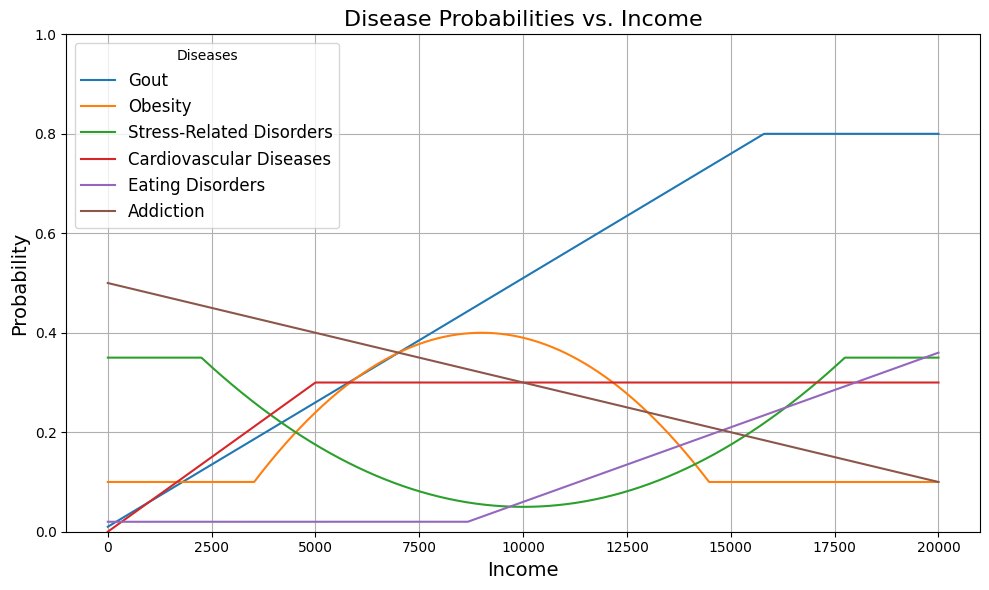

In [21]:
# Generate income range
income = np.linspace(0, 20000, 1000)

# Compute probabilities
gout = [disease_probabilities(inc)["Gout"] for inc in income]
obesity = [disease_probabilities(inc)["Obesity"] for inc in income]
stress = [disease_probabilities(
    inc)["Stress-Related Disorders"] for inc in income]
cardiovascular = [disease_probabilities(
    inc)["Cardiovascular Diseases"] for inc in income]
eating_disorder = [disease_probabilities(
    inc)["Eating Disorders"] for inc in income]
addiction = [disease_probabilities(inc)["Addiction"] for inc in income]

# Plot probabilities
plt.figure(figsize=(10, 6))
plt.plot(income, gout, label="Gout")
plt.plot(income, obesity, label="Obesity")
plt.plot(income, stress, label="Stress-Related Disorders")
plt.plot(income, cardiovascular, label="Cardiovascular Diseases")
plt.plot(income, eating_disorder, label="Eating Disorders")
plt.plot(income, addiction, label="Addiction")

# Customize plot
plt.title("Disease Probabilities vs. Income", fontsize=16)
plt.xlabel("Income", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.ylim(0, 1)
plt.legend(title="Diseases", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
# Function to determine if a person has a disease based on probability
def has_disease(probability):
    return np.random.rand() < probability


# Calculate disease probabilities for each person and add columns to the dataframe
diseases = ["Gout", "Obesity", "Stress-Related Disorders", "Cardiovascular Diseases",
            "Eating Disorders", "Addiction", "Rare Genetic Disease", "Common Allergies", "Hereditary Condition"]

for disease in diseases:
    medical_df[disease] = medical_df['Income'].apply(
        lambda income: has_disease(disease_probabilities(income)[disease]))

# Display the first few rows of the updated dataframe
display(medical_df)

,Name,Age,Gender,Birth Date,Kennitala,Income,Email,Gout,Obesity,Stress-Related Disorders,Cardiovascular Diseases,Eating Disorders,Addiction,Rare Genetic Disease,Common Allergies,Hereditary Condition
8462,Kyle Holland,41.341341,Male,1983-08-31,3108838670,10419.545344,barry29@example.org,False,False,False,True,False,False,False,False,True
3290,Peter Lee,32.832833,Male,1992-03-03,0303928045,7966.049395,andrewcarr@example.org,False,False,False,False,False,False,False,True,True
3275,Robert Burgess,56.856857,Male,1968-02-24,2402688386,8875.020911,billyneal@example.org,False,False,False,True,False,False,False,False,True
3838,Christopher White,76.076076,Male,1948-12-05,0512488669,6442.462490,louis54@example.net,False,True,True,False,False,True,False,True,False
18252,Lauren Duncan,18.618619,Female,2006-05-21,2105068245,2069.355329,sara94@example.net,False,False,True,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,Joshua Trujillo,17.117117,Male,2007-11-20,2011078258,1735.424398,klin@example.com,False,False,True,False,False,True,True,False,True
17533,Brittany Robertson,22.222222,Female,2002-10-13,1310028956,4119.171872,martinelizabeth@example.net,False,False,False,False,False,True,False,False,True
11952,Monique Brown,43.643644,Female,1981-05-12,1205818963,8829.444604,hallkim@example.com,False,False,False,True,False,False,False,False,True
11011,Lindsey Larson,63.563564,Female,1961-06-10,1006618728,7973.503916,jamiemorgan@example.org,False,False,False,False,False,True,False,False,True


In [23]:
# Add a patient_id column with unique integers
medical_df['patient_id'] = range(1, len(medical_df) + 1)

# Display the first few rows of the updated dataframe
display(medical_df)

,Name,Age,Gender,Birth Date,Kennitala,Income,Email,Gout,Obesity,Stress-Related Disorders,Cardiovascular Diseases,Eating Disorders,Addiction,Rare Genetic Disease,Common Allergies,Hereditary Condition,patient_id
8462,Kyle Holland,41.341341,Male,1983-08-31,3108838670,10419.545344,barry29@example.org,False,False,False,True,False,False,False,False,True,1
3290,Peter Lee,32.832833,Male,1992-03-03,0303928045,7966.049395,andrewcarr@example.org,False,False,False,False,False,False,False,True,True,2
3275,Robert Burgess,56.856857,Male,1968-02-24,2402688386,8875.020911,billyneal@example.org,False,False,False,True,False,False,False,False,True,3
3838,Christopher White,76.076076,Male,1948-12-05,0512488669,6442.462490,louis54@example.net,False,True,True,False,False,True,False,True,False,4
18252,Lauren Duncan,18.618619,Female,2006-05-21,2105068245,2069.355329,sara94@example.net,False,False,True,False,False,True,False,True,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,Joshua Trujillo,17.117117,Male,2007-11-20,2011078258,1735.424398,klin@example.com,False,False,True,False,False,True,True,False,True,4996
17533,Brittany Robertson,22.222222,Female,2002-10-13,1310028956,4119.171872,martinelizabeth@example.net,False,False,False,False,False,True,False,False,True,4997
11952,Monique Brown,43.643644,Female,1981-05-12,1205818963,8829.444604,hallkim@example.com,False,False,False,True,False,False,False,False,True,4998
11011,Lindsey Larson,63.563564,Female,1961-06-10,1006618728,7973.503916,jamiemorgan@example.org,False,False,False,False,False,True,False,False,True,4999


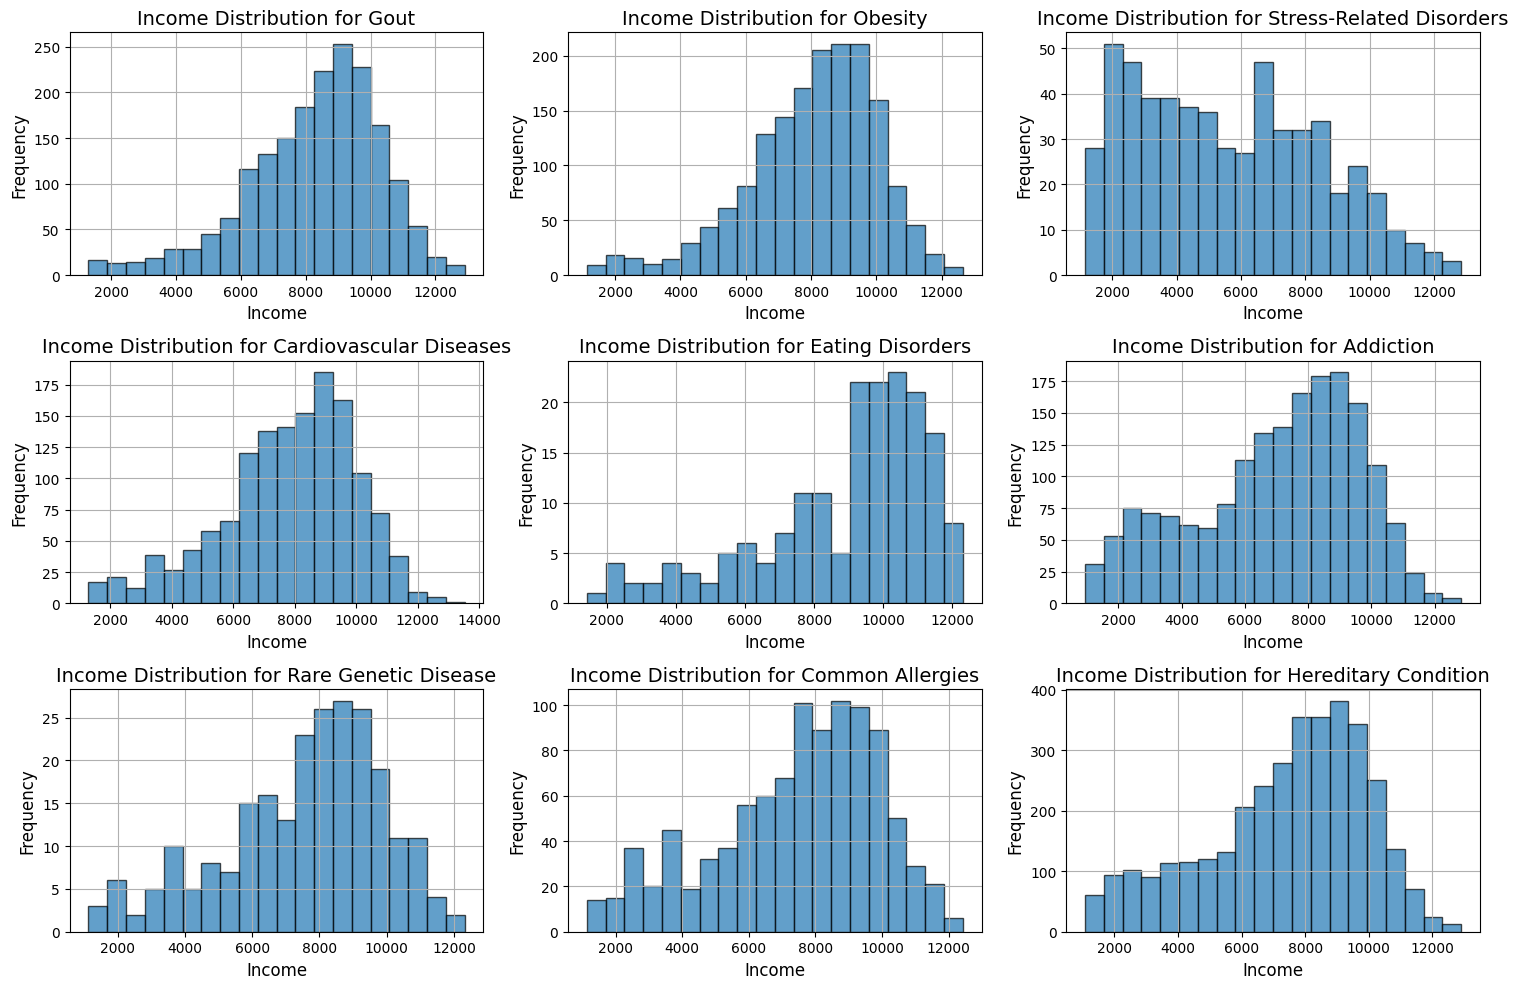

In [24]:
# List of diseases
diseases = ["Gout", "Obesity", "Stress-Related Disorders", "Cardiovascular Diseases",
            "Eating Disorders", "Addiction", "Rare Genetic Disease", "Common Allergies", "Hereditary Condition"]

# Plot the distribution of each disease with respect to income
plt.figure(figsize=(15, 10))

for i, disease in enumerate(diseases, 1):
    plt.subplot(3, 3, i)
    plt.hist(medical_df[medical_df[disease]]['Income'],
             bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Income Distribution for {disease}', fontsize=14)
    plt.xlabel('Income', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()

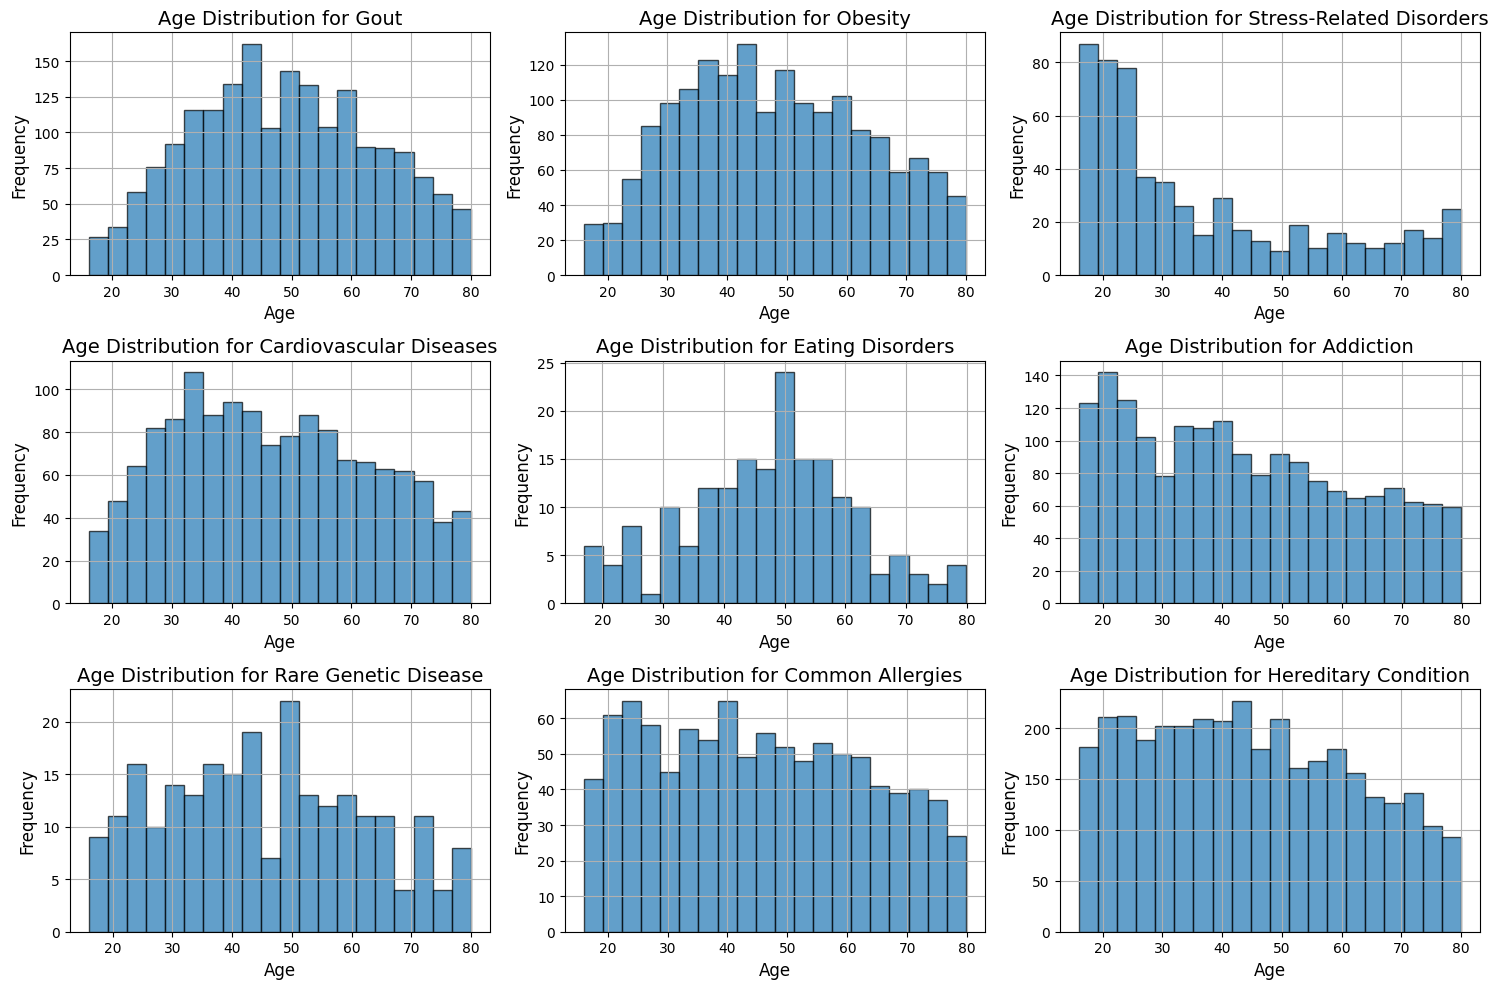

In [25]:
# List of diseases
diseases = ["Gout", "Obesity", "Stress-Related Disorders", "Cardiovascular Diseases",
            "Eating Disorders", "Addiction", "Rare Genetic Disease", "Common Allergies", "Hereditary Condition"]

# Plot the distribution of each disease with respect to age
plt.figure(figsize=(15, 10))

for i, disease in enumerate(diseases, 1):
    plt.subplot(3, 3, i)
    plt.hist(medical_df[medical_df[disease]]['Age'],
             bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Age Distribution for {disease}', fontsize=14)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_70503/3846808154.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_distribution = hagstofa_df.groupby(income_categories).size()


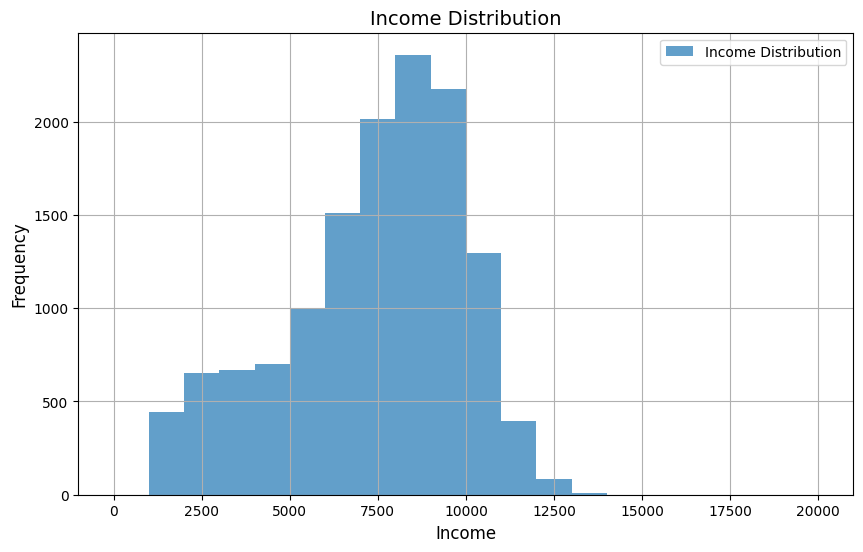

/tmp/ipykernel_70503/3846808154.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3846808154.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3846808154.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical

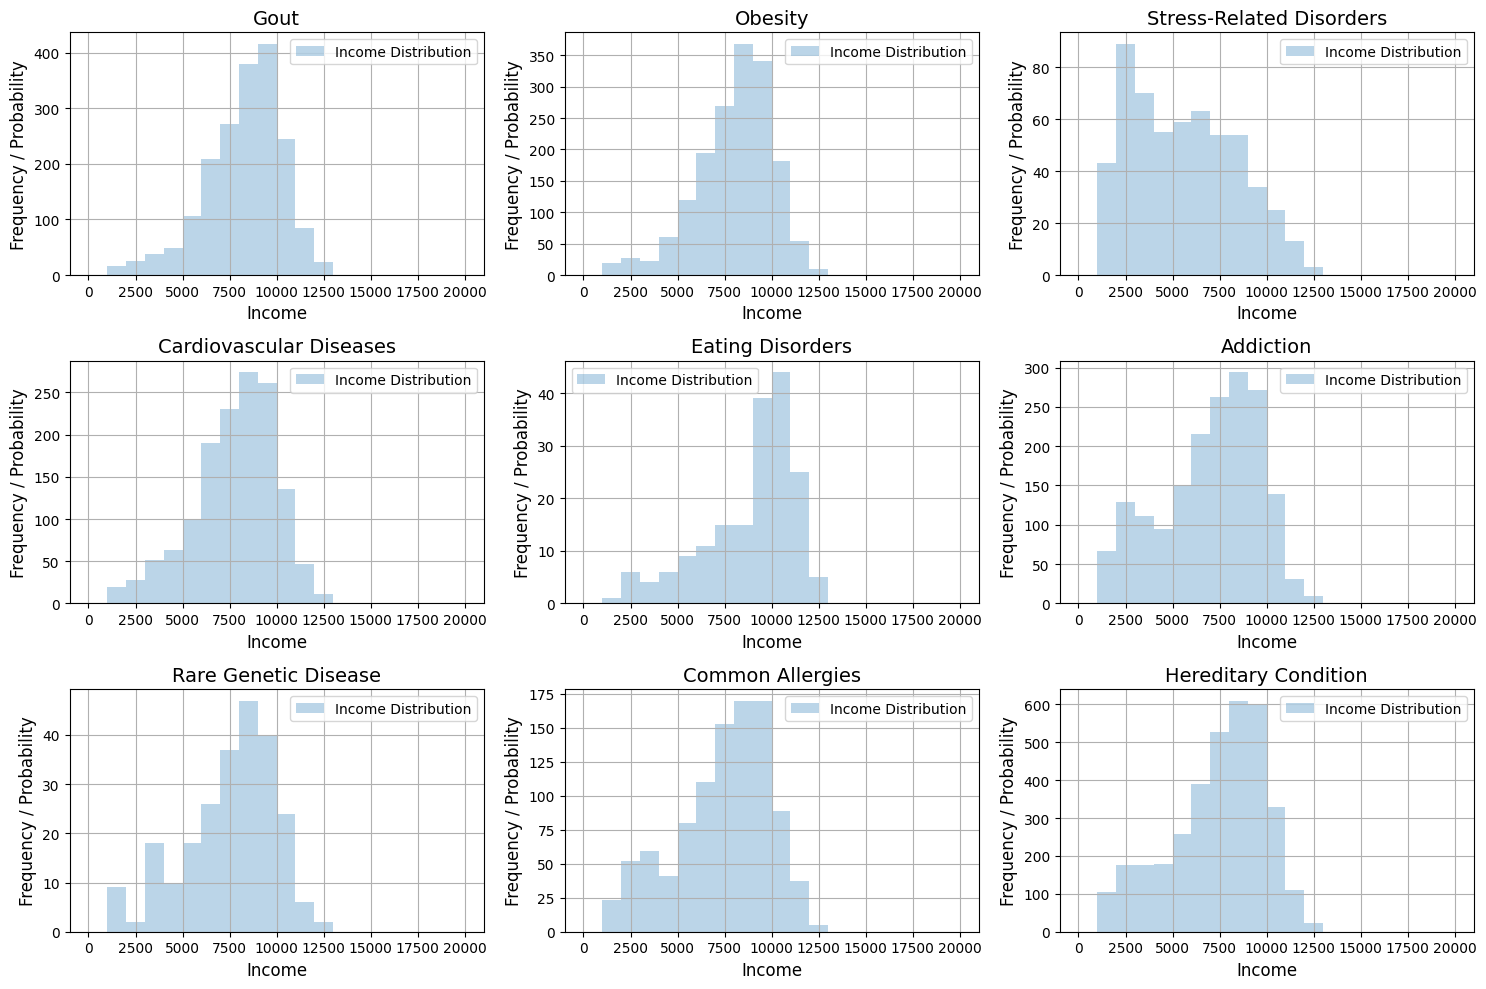

/tmp/ipykernel_70503/3846808154.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3846808154.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3846808154.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical

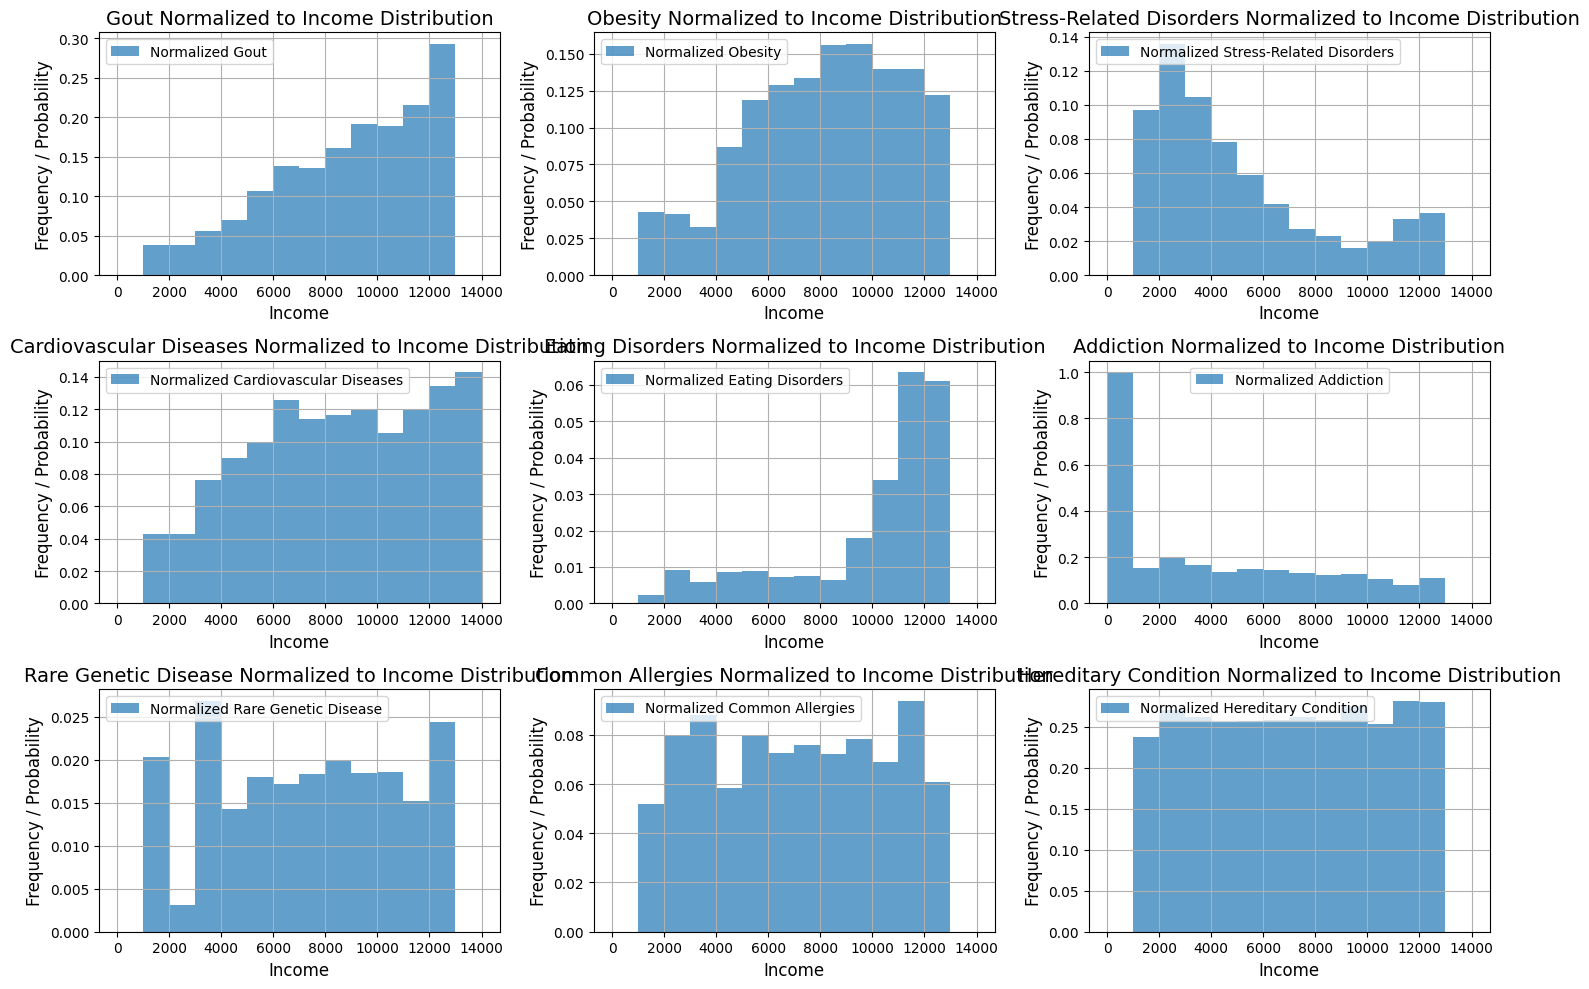

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define income range and bins
income_bins = np.linspace(0, 20000, 21)  # 20 bins between 0 and 20,000
income_categories = pd.cut(hagstofa_df['Income'], bins=income_bins)

# Count total individuals in each income category
income_distribution = hagstofa_df.groupby(income_categories).size()


# Plot the income distribution
plt.figure(figsize=(10, 6))
plt.bar(income_bins[:-1] + np.diff(income_bins) / 2, income_distribution,
        width=np.diff(income_bins), alpha=0.7, label='Income Distribution')
plt.title('Income Distribution', fontsize=14)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Initialize plot
plt.figure(figsize=(15, 10))

for i, disease in enumerate(diseases, 1):
    # Filter individuals with the given disease
    disease_distribution = medical_df[medical_df[disease]].groupby(
        pd.cut(medical_df[medical_df[disease]]['Income'], bins=income_bins)
    ).size()

    # Plot original income distribution
    plt.subplot(3, 3, i)
    plt.bar(income_bins[:-1] + np.diff(income_bins) / 2, disease_distribution,
            width=np.diff(income_bins), alpha=0.3, label='Income Distribution')

    # Plot normalized disease distribution
    plt.title(f'{disease}', fontsize=14)
    plt.xlabel('Income', fontsize=12)
    plt.ylabel('Frequency / Probability', fontsize=12)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


# Initialize plot
plt.figure(figsize=(15, 10))

for i, disease in enumerate(diseases, 1):
    # Filter individuals with the given disease
    disease_distribution = medical_df[medical_df[disease]].groupby(
        pd.cut(medical_df[medical_df[disease]]['Income'], bins=income_bins)
    ).size()

    # Normalize disease distribution to the income distribution
    normalized_distribution = disease_distribution / income_distribution

    # Plot original income distribution
    plt.subplot(3, 3, i)

    # Plot normalized disease distribution
    plt.bar(income_bins[:-1] + np.diff(income_bins) / 2, normalized_distribution,
            width=np.diff(income_bins), alpha=0.7, label=f'Normalized {disease}')

    plt.title(f'{disease} Normalized to Income Distribution', fontsize=14)
    plt.xlabel('Income', fontsize=12)
    plt.ylabel('Frequency / Probability', fontsize=12)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_70503/3943588612.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution = hagstofa_df.groupby(age_categories).size()


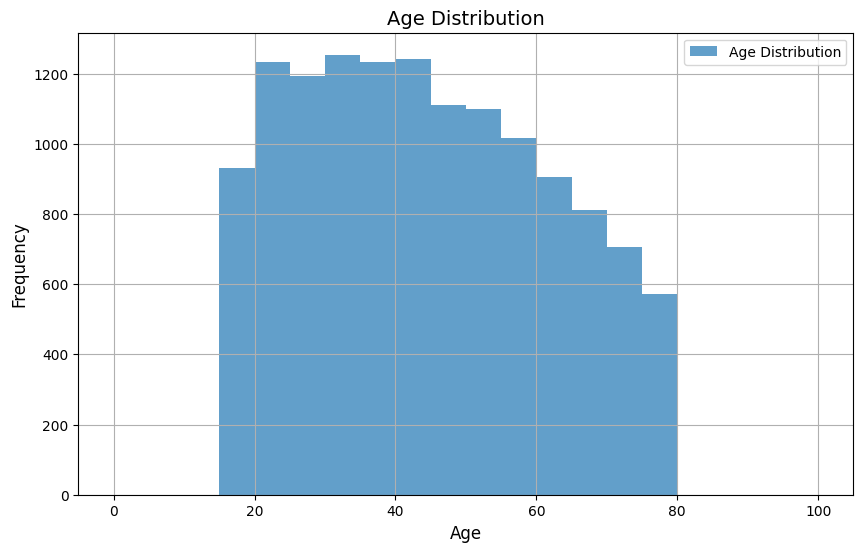

/tmp/ipykernel_70503/3943588612.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3943588612.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3943588612.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical

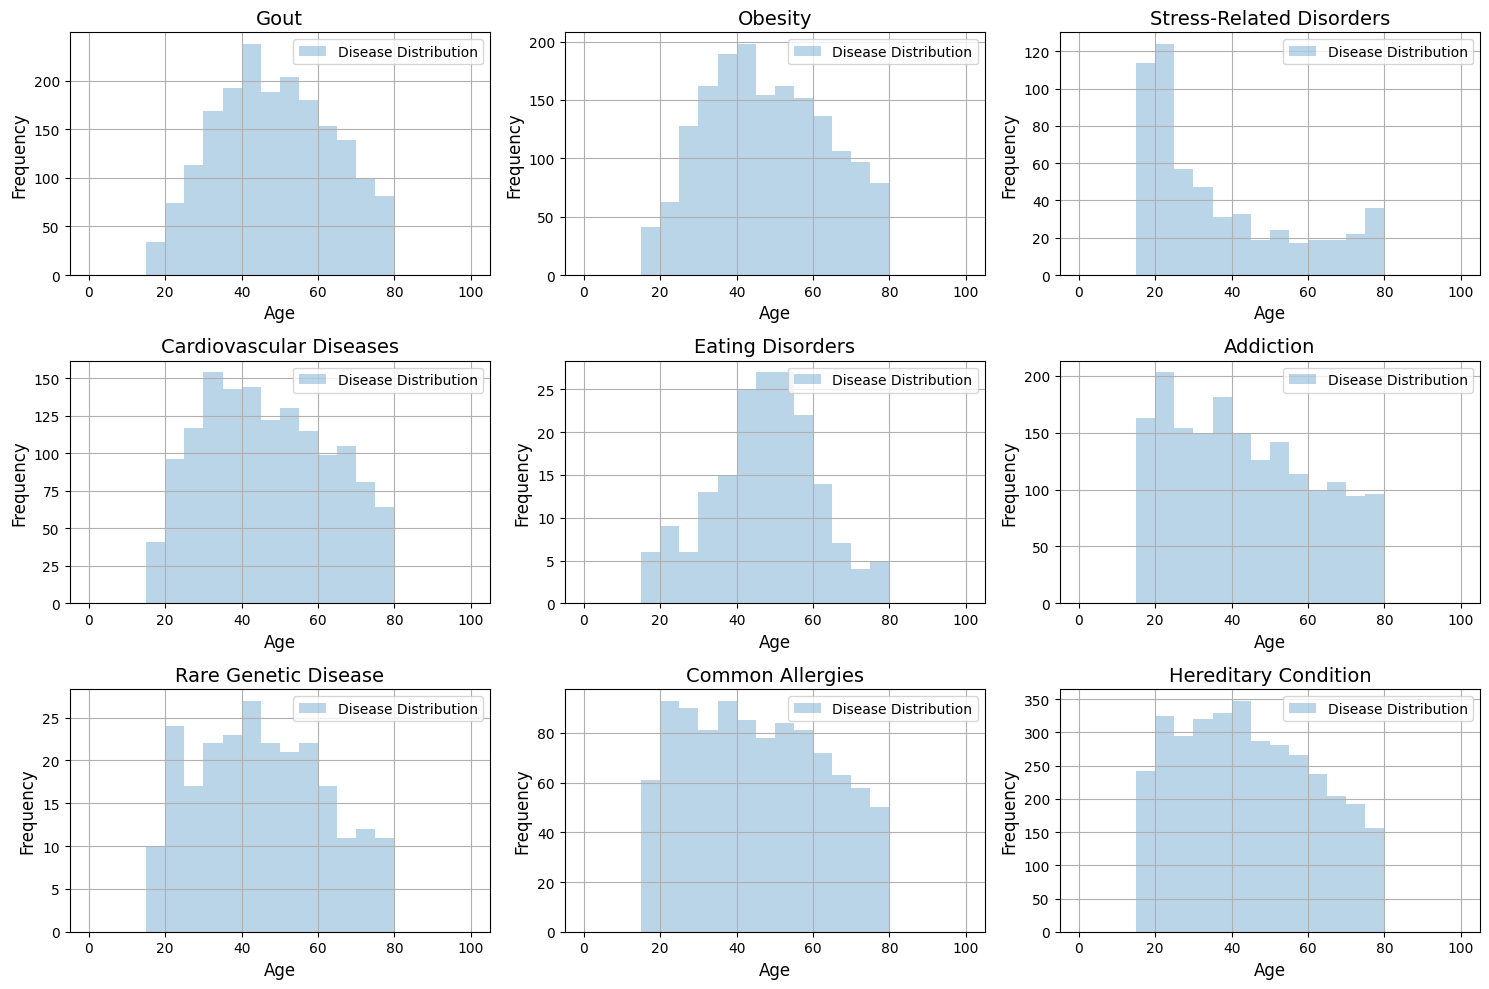

/tmp/ipykernel_70503/3943588612.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3943588612.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical_df[disease]].groupby(
/tmp/ipykernel_70503/3943588612.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disease_distribution = medical_df[medical

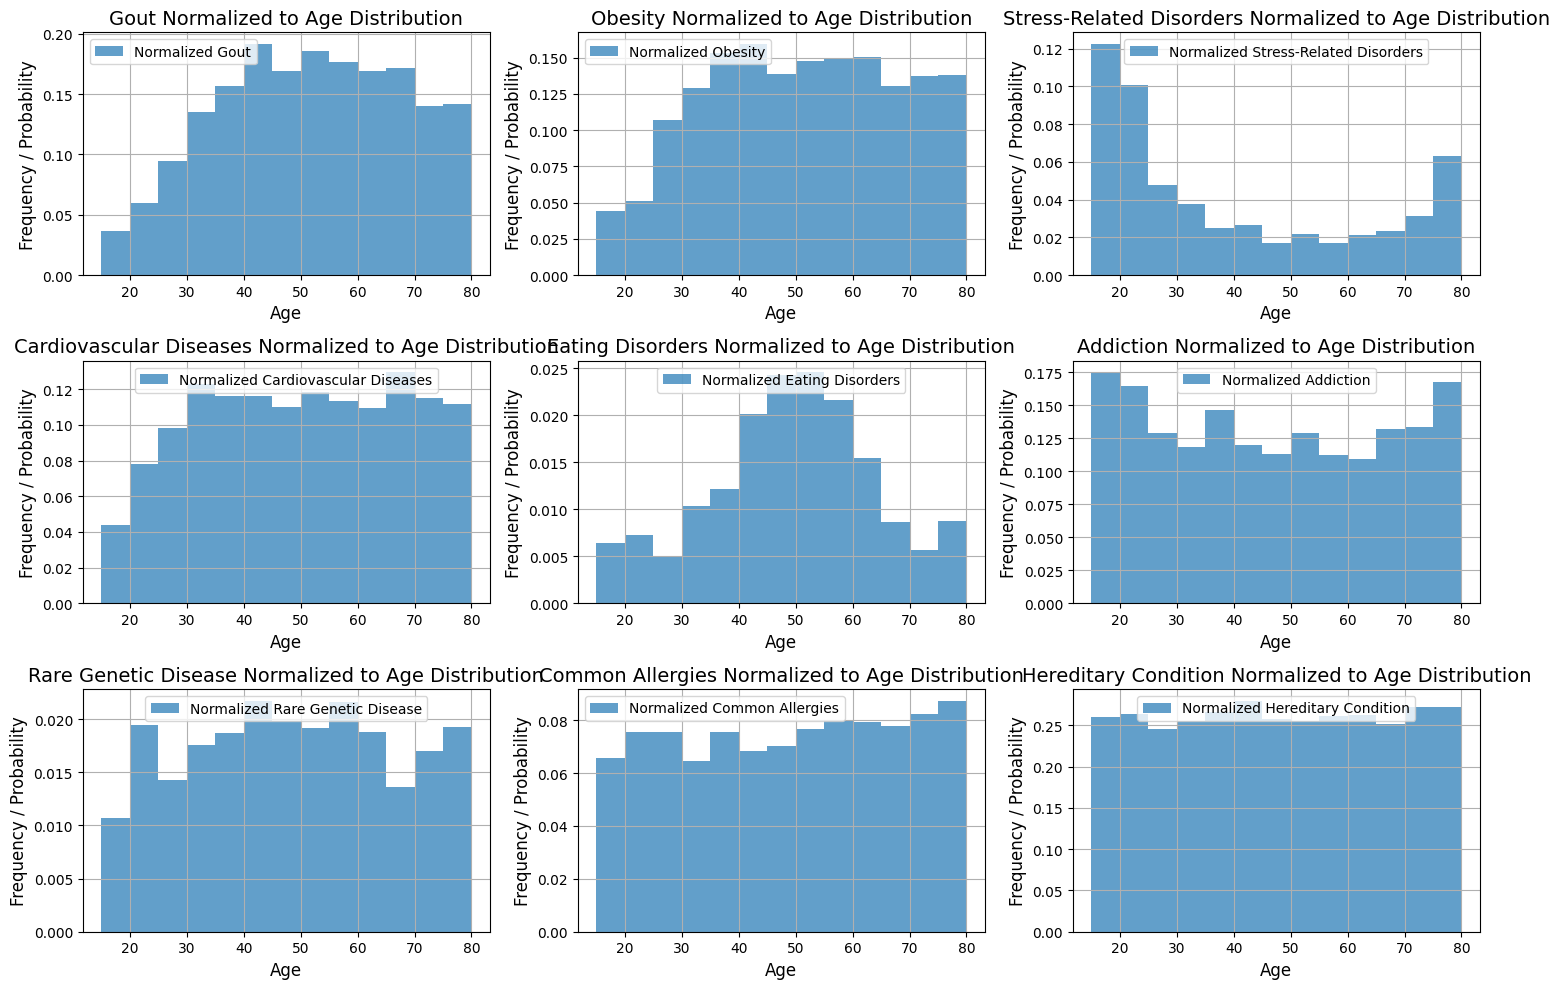

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define age range and bins
age_bins = np.linspace(0, 100, 21)  # 20 bins between 0 and 100
age_categories = pd.cut(hagstofa_df['Age'], bins=age_bins)

# Count total individuals in each age category
age_distribution = hagstofa_df.groupby(age_categories).size()

# Plot the age distribution
plt.figure(figsize=(10, 6))
plt.bar(age_bins[:-1] + np.diff(age_bins) / 2, age_distribution,
        width=np.diff(age_bins), alpha=0.7, label='Age Distribution')
plt.title('Age Distribution', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# Initialize plot
plt.figure(figsize=(15, 10))

for i, disease in enumerate(diseases, 1):
    # Filter individuals with the given disease
    disease_distribution = medical_df[medical_df[disease]].groupby(
        pd.cut(medical_df[medical_df[disease]]['Age'], bins=age_bins)
    ).size()

    # Plot disease distribution
    plt.subplot(3, 3, i)
    plt.bar(age_bins[:-1] + np.diff(age_bins) / 2, disease_distribution,
            width=np.diff(age_bins), alpha=0.3, label='Disease Distribution')

    plt.title(f'{disease}', fontsize=14)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Initialize plot
plt.figure(figsize=(15, 10))

for i, disease in enumerate(diseases, 1):
    # Filter individuals with the given disease
    disease_distribution = medical_df[medical_df[disease]].groupby(
        pd.cut(medical_df[medical_df[disease]]['Age'], bins=age_bins)
    ).size()

    # Normalize disease distribution to the age distribution
    normalized_distribution = disease_distribution / age_distribution

    # Plot normalized disease distribution
    plt.subplot(3, 3, i)
    plt.bar(age_bins[:-1] + np.diff(age_bins) / 2, normalized_distribution,
            width=np.diff(age_bins), alpha=0.7, label=f'Normalized {disease}')

    plt.title(f'{disease} Normalized to Age Distribution', fontsize=14)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Frequency / Probability', fontsize=12)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

In [28]:
medical_df = medical_df.drop(columns=['Income', 'Email'])
medical_df.to_csv('medical_data.csv', index=False)